# Quickstart
SIR model is used for an example. Explanation of SIR model can be found [here](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model).

First, import a module. 

In [1]:
import matplotlib.pyplot as plt
import py_compart_model as pcm

Prepare parameters for SIR model.

In [2]:
R0 = 2
gamma = 1/10
N = 100
beta = R0*gamma/N

Set parameters and compartment model with values or without values. Model definition should be defined inside a context manager, but you can specify initial values for each compartment and values for parameters outside a context manager.

In [3]:
_beta  = pcm.Param("beta")
_gamma = pcm.Param("gamma", value=gamma)
with pcm.Model() as m:
    S = m.C("S")
    I = m.C("I")
    R = m.C("R", value=0) 
    S.d = - _beta * S * I 
    I.d = + _beta * S * I - _gamma * I
    R.d = + _gamma * I 

Pass parameters to the model, and create a function for fitting. Currently, py_compart_model takes approch to generate string form of function and execute this string to create function. Since pure function is applied, there is no overhead for calculation for this package. 

In [4]:
m.create_function((_beta,_gamma))

def _f(t, y, beta, gamma):
    S = y[0]
    I = y[1]
    R = y[2]
    dS =  - beta * (S) * (I)
    dI =  + beta * (S) * (I) - gamma * (I)
    dR =  + gamma * (I)
    return [dS,dI,dR]


Values for parameters and initial values for compartments can be specified after create_function method. This allows us to simulate a model, varying parameters and initial values. 

In [5]:
_beta.set_value(beta)
S.set_init(N-1)
I.set_init(1)

Then, solve equation. At present, solve uses solve_ivp implemented in scipy. kargs is passed to solve_ivp function.

In [6]:
ode_res = m.solve([0,200], max_step=0.1)

Summary print out inits, args and message for solving results. 

In [7]:
ode_res.summary()

inits : {'S': 99, 'I': 1, 'R': 0}
args : {'beta': 0.002, 'gamma': 0.1}
message : The solver successfully reached the end of the integration interval.



Can access to results of solve_ivp, and results of y are mapped to its variables. 

In [8]:
res = ode_res.result
print(res)
print(res.I)

        I: array([1.        , 1.00138615, 1.0112454 , ..., 0.003735  , 0.00371264,
       0.00369355])
        R: array([0.00000000e+00, 1.41447896e-03, 1.14775596e-02, ...,
       8.00141757e+01, 8.00142130e+01, 8.00142448e+01])
        S: array([99.        , 98.99719937, 98.97727704, ..., 19.98208926,
       19.98207438, 19.98206167])
  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 12008
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 1.41349951e-02, 1.14134995e-01, ...,
       1.99814135e+02, 1.99914135e+02, 2.00000000e+02])
 t_events: None
        y: array([[9.90000000e+01, 9.89971994e+01, 9.89772770e+01, ...,
        1.99820893e+01, 1.99820744e+01, 1.99820617e+01],
       [1.00000000e+00, 1.00138615e+00, 1.01124540e+00, ...,
        3.73499825e-03, 3.71264206e-03, 3.69355271e-03],
       [0.00000000e+00, 1.41447896e-03, 1.14775596e-02, ...,
        8.00141757e+01, 8.00142130e+01, 

For visualization. 

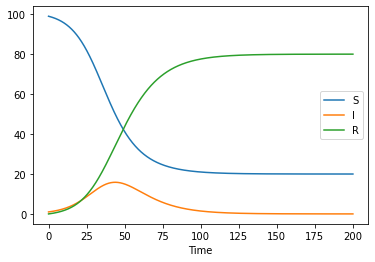

In [9]:
pcm.plot_over_time(ode_res)

you can pass ax to control visualization and specify both compartment by sting or Compartments class used in contextmanager for plotting.

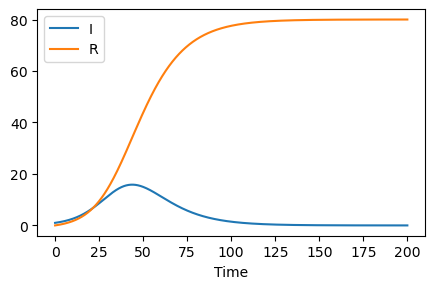

In [10]:
fig = plt.figure(figsize=(5,3),dpi=100)
ax = fig.add_subplot(111)
pcm.plot_over_time(ode_res, comparts=["I", R], ax=ax)

## Note 
Since this package is not mature, it does not support 
- Matrix arguments, specify size for each compoment to include stratified simulation. 
- Does not gurantee no weired behaviors. I can not cover all problems caused from string generated functions.  

If you want to improve it, please help me to develop a better one!! 

# Motivation
If you want to use solve_ivp, you should concatate variables into one. This task is redundunt and causes mistakes. If you want to implement the same SIR model described in Quickstart, code becomes like,

In [11]:
from scipy.integrate import solve_ivp

In [12]:
def sir(t,y,beta, gamma):
    S = y[0]
    I = y[1]
    R = y[2]
    dS = - beta * S * I
    dI = + beta * S * I - gamma*I
    dR = + gamma*I
    d = [dS,dI,dR]
    return d

R0 = 2
gamma = 1/10
N = 100
beta = R0*gamma/N
res = solve_ivp(sir, [0,200], [N - 1,1,0], args=(beta, gamma),  max_step=0.1)

So, you should be very careful about orders about passing parameters for both initial values and parameter values. Also you have to decompose results into compartment names if you want to handle with results.   
This package removes these processes, and preserves calculation speed as natively implemented version, since the package is just a syntax suger.